In [ ]:
import pickle
import seaborn as sns
import pandas as pd
from Evaluation import generate_test_subjects
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm_notebook as tqdm
import scipy
from scipy.ndimage import zoom
from fsl.data.image import Image
from fsl.utils.image import resample
import torchio as tio
import glob
from sklearn.model_selection import train_test_split
import argparse
import os
from Preprocess import write_data
from utils import plot_images
import pandas as pd
from skimage.metrics import structural_similarity as ssim_sklearn

In [3]:
def show_slices(slices):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(len(slices), len(slices[0]))
    fig.set_size_inches(15,7.5)
    for row in range(len(slices)):
        for column in range(len(slices[0])):
            axes[row][column].imshow(slices[row][column].T, cmap="gray", origin="lower")


def plot_images(inp_np,res_np):
    slice_0 = inp_np[int(inp_np.shape[0]/2), :, :]
    slice_1 = inp_np[:, int(inp_np.shape[1]/2), :]
    slice_2 = inp_np[:, :, int(inp_np.shape[2]/2)]
    nslice_0 = res_np[int(res_np.shape[0]/2), :, :]
    nslice_1 = res_np[:, int(res_np.shape[1]/2), :]
    nslice_2 = res_np[:, :, int(res_np.shape[2]/2)]
    show_slices([[slice_0, slice_1, slice_2],
                 [nslice_0, nslice_1, nslice_2]])

In [ ]:
actual_images = os.listdir(os.path.join("IXI-T1","Actual_Images"))
target_dir = os.listdir(os.path.join("IXI-T1","Compressed_4.0x4.0x1.2"))
pix_dims = [4,4,1.2]
for scan in tqdm(actual_images):
    fname = os.path.join("IXI-T1","Actual_Images",scan)
    img   = Image(fname)
    plot_images(img,img)
    resample_img = resample.resampleToPixdims(img, pix_dims)
    write_data(resample_img[0],scan,resample_img[1],pix_dims,"IXI-T1")

In [ ]:
print(img.shape)

In [ ]:
test_subjects = generate_test_subjects()

In [ ]:
len(test_subjects[0])

In [ ]:
fname = os.path.join("IXI-T1","Actual_Images",actual_images[0])
img   = Image(fname)
pix_dims = [4,4,1.2]
resample_img = resample.resampleToPixdims(img, pix_dims)
print(img.shape,resample_img[0].shape)
plot_images(img,resample_img[0])

In [ ]:
zoom_factor = np.array(img.shape) / np.array(resample_img[0].shape)
zoomed = zoom(resample_img[0], zoom_factor, order=3)

plot_images(img,zoomed)

Set the mode based on the method of interpolation required
0 - Nearest
1 - Bilinear
3 - Bicubic

In [ ]:
mode = 0

In [ ]:
results = {}
modes = [0,1,3]

for mode in modes:
    ssim_list = []
    for subject in tqdm(test_subjects):
        gt,comp = np.squeeze(subject.ground_truth["data"].numpy()),np.squeeze(subject.compressed["data"].numpy())
        zoom_factor = np.array(gt.shape) / np.array(comp.shape)
        zoomed = zoom(comp, zoom_factor, order=mode)
        plot_images(gt,comp)
        ssim = ssim_sklearn(zoomed,gt,data_range = gt.max()-gt.min())
        ssim_list.append(ssim)
    if mode == 0:
        results['nearest'] = ssim_list
    elif mode == 1:
        results['bilinear']= ssim_list
    else:
        results["bicubic"] = ssim_list

with open("legacy_methods.pickle",'wb') as handler:
    pickle.dump(results,handler)

In [ ]:
with open("legacy_methods.pickle",'rb') as handler:
    results = pickle.load(handler)



In [ ]:
with open("ssims_variable_kernel.data",'rb') as handler2:
    dictionary = pickle.load(handler2)

results["Densenet"] = dictionary['Compressed_4.0x4.0x1.2']
df = pd.DataFrame.from_dict(results)
sns.boxplot(data=df).set_title("Super resolution on 4x4x1.2 images")

In [ ]:
import torch
import torchio
import matplotlib.pyplot as plt
from utils import plot_images
import DenseNetModel
from pathlib import Path
from sklearn.model_selection import train_test_split
import os
import torchio as tio
from torchio.transforms import Compose,ZNormalization,RescaleIntensity
from torchio import AFFINE,DATA
import random
import pickle
import seaborn as sns
import pandas as pd

In [ ]:
def write_image(slice_list,ssim):
    print("writing image.......")
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle("ssim : {}".format(ssim))
    ax[0].imshow(slice_list[0], interpolation='nearest', origin="lower", cmap="gray")
    ax[0].set_title("Original")
    ax[0].set_axis_off()
    ax[1].imshow(slice_list[1], interpolation='nearest', origin="lower", cmap="gray")
    ax[1].set_title("Bicubic")
    ax[1].set_axis_off()
    ax[2].imshow(slice_list[2], interpolation='nearest', origin="lower", cmap="gray")
    ax[2].set_title("Predicted")
    ax[2].set_axis_off()
    plt.show()

In [ ]:
def test_network(sample):
    patch_size = 48,48,48
    patch_overlap = 4,4,4
    model.eval()
    grid_sampler = tio.inference.GridSampler(sample,patch_size,patch_overlap)
    patch_loader = torch.utils.data.DataLoader(grid_sampler,int(validation_batch_size/4))
    aggregator = tio.inference.GridAggregator(grid_sampler,overlap_mode="average")
    with torch.no_grad():
        for batch in tqdm(patch_loader):
            inputs = batch["compressed"][DATA].to("cuda")
            logits = model(inputs)
            location = batch[tio.LOCATION]
            aggregator.add_batch(logits,location)
    model.train()
    result = aggregator.get_output_tensor()
    original, compressed = sample.ground_truth["data"].squeeze(), sample.compressed["data"].squeeze()
    result = torch.squeeze(result)
    original,compressed,result = original.detach().cpu().numpy(),compressed.detach().cpu().numpy(),result.detach().cpu().numpy()
    ssim_val = ssim_sklearn(original,result,data_range=original.max()-original.min())
    return original,compressed,result,ssim_val

In [ ]:
state_dict = torch.load("Models/DenseNet varying kernel with scale augmentation/denseNet3D_torchIO_patch_32_samples_20_ADAMOptim_50Epochs_BS12_GlorotWeights_SSIM_1511.pth")
model = DenseNetModel.DenseNet(num_init_features=4,growth_rate=6,block_config=(6,6,6)).to("cuda")
model.load_state_dict(state_dict["model_state_dict"])
validation_batch_size = 12
test_transform = Compose([RescaleIntensity((0,1))])

test_subjects = generate_test_subjects()
samples = random.sample(test_subjects[0],5)
test_dataset = tio.SubjectsDataset(samples,transform=test_transform)



for sample in test_dataset:
    original,compressed,result,ssim_val = test_network(sample)
    slice_original = (original[:, :, int(original.shape[2] / 2)])
    slice_compressed = (compressed[:, :, int(compressed.shape[2] / 2)])
    slice_result = (result[:, :, int(result.shape[2] / 2)])
    slice_list = [slice_original.T,slice_compressed.T,slice_result.T]
    write_image(slice_list,ssim_val)

In [ ]:
ground_truths = Path("IXI-T1/Actual_Images")
ground_paths = sorted(ground_truths.glob('*.nii.gz'))

compressed = Path("IXI-T1/Compressed")
compressed_paths = sorted(compressed.glob('*.nii.gz'))

image_batch = 3


device = "cuda" if torch.cuda.is_available() else "cpu"
subjects=[]
transform = Compose([RescaleIntensity((0,1))])

for gt,comp in zip(ground_paths,compressed_paths):
    
    subject = tio.Subject(
                    ground_truth = tio.ScalarImage(gt),
                    compressed = tio.ScalarImage(comp,dtype=torch.int16)
                    )
    subjects.append(subject)

dataset = tio.SubjectsDataset(subjects)

In [ ]:
np.seterr(over='raise')

In [ ]:
for idx,subject in enumerate(dataset):
    print(idx)

In [ ]:
print(dataset[131].compressed[DATA].min())

In [ ]:
gt = dataset[131].ground_truth[DATA]
gt2 = dataset[130].ground_truth[DATA]

print(torch.max(gt),torch.min(gt),gt.dtype)
print(torch.max(gt2),torch.min(gt2),gt2.dtype)

In [ ]:
gt = dataset[131].compressed[DATA]
gt2 = dataset[130].compressed[DATA]
print(torch.max(gt),torch.min(gt),gt.dtype)
print(torch.max(gt2),torch.min(gt2),gt2.dtype)

In [ ]:
intensity = "IXI-T1"
ground_dir = os.path.join(intensity, "Actual_Images")
scans = os.listdir(ground_dir)
compressed_dir = os.path.join(intensity, "Compressed")
target_dir = os.path.join(intensity,"Interpolated")

for scan in scans:
    image_path = os.path.join(compressed_dir,scan)
    source_path = os.path.join(ground_dir,scan)
    comp_image = tio.ScalarImage(image_path)[DATA]
    print(tio.ScalarImage(image_path)[AFFINE])
    source_image = tio.ScalarImage(source_path)[DATA]
    interpolation = interpolate(comp_image.unsqueeze(dim=0),source_image.squeeze().shape)
    break

In [ ]:
plot_images(interpolation.squeeze().numpy(),comp_image.squeeze().numpy())

In [ ]:
training_subjects,test_subjects,validation_subjects = train_test_val_split()

In [ ]:
print(len(training_subjects),len(test_subjects),len(validation_subjects))

In [1]:
import matplotlib.pyplot as plt
import os
from pathlib import Path
import torchio as tio
from sklearn.model_selection import train_test_split
import torchio as tio
from torchio import AFFINE,DATA
import torchcomplex as torchc
from torchio.transforms import Compose,Resample,RescaleIntensity
from torchcomplex.nn.functional import interpolate
from tqdm import tqdm
import torch
import numpy as np
from fsl.data.image import Image
import DenseNetModel
from utils import train_test_val_split
from pytorch_modelsize import SizeEstimator
from torchsummary import summary
import UNetModel

If you use TorchIO for your research, please cite the following paper:
Pérez-García et al., TorchIO: a Python library for efficient loading,
preprocessing, augmentation and patch-based sampling of medical images
in deep learning. Credits instructions: https://torchio.readthedocs.io/#credits



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNetModel.DenseNet(num_init_features=12,growth_rate=7,block_config=(6,6,6)).to(device)

In [ ]:
summary(model,input_size=(1,48,48,48))

In [ ]:
model = UNetModel.Unet(1,1,8).to(device)
summary(model,input_size=(1,64,64,64))

In [2]:

intensity = 'IXI-T2'
ground_dir = os.path.join(intensity, "Actual_Images")
scans = os.listdir(ground_dir)
compressed_dir = os.path.join(intensity, "Compressed")
# target_dir = os.path.join(intensity, "Interpolated")
for scan in scans:
    image_path = os.path.join(compressed_dir, scans[3])
    source_path = os.path.join(ground_dir, scans[3])
    comp_image = tio.ScalarImage(image_path)[DATA]
    source_image = tio.ScalarImage(source_path)[DATA]
    print(comp_image.shape, source_image.shape)

torch.Size([1, 128, 128, 65]) torch.Size([1, 256, 256, 130])
torch.Size([1, 128, 128, 56]) torch.Size([1, 256, 256, 112])
torch.Size([1, 128, 128, 58]) torch.Size([1, 256, 256, 116])
torch.Size([1, 128, 128, 14]) torch.Size([1, 256, 256, 28])
torch.Size([1, 128, 128, 60]) torch.Size([1, 256, 256, 120])
torch.Size([1, 128, 128, 60]) torch.Size([1, 256, 256, 120])
torch.Size([1, 128, 128, 63]) torch.Size([1, 256, 256, 125])
torch.Size([1, 128, 128, 65]) torch.Size([1, 256, 256, 130])
torch.Size([1, 128, 128, 60]) torch.Size([1, 256, 256, 120])
torch.Size([1, 128, 128, 65]) torch.Size([1, 256, 256, 130])
torch.Size([1, 128, 128, 65]) torch.Size([1, 256, 256, 130])
torch.Size([1, 128, 128, 60]) torch.Size([1, 256, 256, 120])
torch.Size([1, 128, 128, 65]) torch.Size([1, 256, 256, 130])
torch.Size([1, 128, 128, 65]) torch.Size([1, 256, 256, 130])
torch.Size([1, 128, 128, 60]) torch.Size([1, 256, 256, 120])
torch.Size([1, 128, 128, 65]) torch.Size([1, 256, 256, 130])
torch.Size([1, 128, 128, 

torch.Size([1, 128, 128, 65]) torch.Size([1, 256, 256, 130])
torch.Size([1, 128, 128, 65]) torch.Size([1, 256, 256, 130])
torch.Size([1, 128, 128, 65]) torch.Size([1, 256, 256, 130])
torch.Size([1, 128, 128, 65]) torch.Size([1, 256, 256, 130])
torch.Size([1, 128, 128, 65]) torch.Size([1, 256, 256, 130])
torch.Size([1, 128, 128, 65]) torch.Size([1, 256, 256, 130])
torch.Size([1, 128, 128, 65]) torch.Size([1, 256, 256, 130])
torch.Size([1, 128, 128, 65]) torch.Size([1, 256, 256, 130])
torch.Size([1, 128, 128, 65]) torch.Size([1, 256, 256, 130])
torch.Size([1, 128, 128, 65]) torch.Size([1, 256, 256, 130])
torch.Size([1, 128, 128, 65]) torch.Size([1, 256, 256, 130])
torch.Size([1, 128, 128, 65]) torch.Size([1, 256, 256, 130])
torch.Size([1, 128, 128, 65]) torch.Size([1, 256, 256, 130])
torch.Size([1, 128, 128, 65]) torch.Size([1, 256, 256, 130])
torch.Size([1, 128, 128, 65]) torch.Size([1, 256, 256, 130])
torch.Size([1, 128, 128, 65]) torch.Size([1, 256, 256, 130])
torch.Size([1, 128, 128,

torch.Size([1, 128, 128, 68]) torch.Size([1, 256, 256, 136])
torch.Size([1, 128, 128, 65]) torch.Size([1, 256, 256, 130])
torch.Size([1, 128, 128, 65]) torch.Size([1, 256, 256, 130])
torch.Size([1, 128, 128, 65]) torch.Size([1, 256, 256, 130])
torch.Size([1, 128, 128, 68]) torch.Size([1, 256, 256, 136])
torch.Size([1, 128, 128, 68]) torch.Size([1, 256, 256, 136])
torch.Size([1, 128, 128, 65]) torch.Size([1, 256, 256, 130])
torch.Size([1, 128, 128, 65]) torch.Size([1, 256, 256, 130])
torch.Size([1, 128, 128, 65]) torch.Size([1, 256, 256, 130])
torch.Size([1, 128, 128, 65]) torch.Size([1, 256, 256, 130])
torch.Size([1, 128, 128, 65]) torch.Size([1, 256, 256, 130])
torch.Size([1, 128, 128, 65]) torch.Size([1, 256, 256, 130])
torch.Size([1, 128, 128, 68]) torch.Size([1, 256, 256, 136])
torch.Size([1, 128, 128, 65]) torch.Size([1, 256, 256, 130])
torch.Size([1, 128, 128, 65]) torch.Size([1, 256, 256, 130])
torch.Size([1, 128, 128, 65]) torch.Size([1, 256, 256, 130])
torch.Size([1, 128, 128,

torch.Size([1, 128, 128, 65]) torch.Size([1, 256, 256, 130])
torch.Size([1, 128, 128, 65]) torch.Size([1, 256, 256, 130])
torch.Size([1, 128, 128, 65]) torch.Size([1, 256, 256, 130])
torch.Size([1, 128, 128, 65]) torch.Size([1, 256, 256, 130])
torch.Size([1, 128, 128, 65]) torch.Size([1, 256, 256, 130])
torch.Size([1, 128, 128, 65]) torch.Size([1, 256, 256, 130])
torch.Size([1, 128, 128, 65]) torch.Size([1, 256, 256, 130])
torch.Size([1, 128, 128, 68]) torch.Size([1, 256, 256, 136])
torch.Size([1, 128, 128, 68]) torch.Size([1, 256, 256, 136])
torch.Size([1, 128, 128, 68]) torch.Size([1, 256, 256, 136])
torch.Size([1, 128, 128, 65]) torch.Size([1, 256, 256, 130])
torch.Size([1, 128, 128, 65]) torch.Size([1, 256, 256, 130])
torch.Size([1, 128, 128, 65]) torch.Size([1, 256, 256, 130])
torch.Size([1, 128, 128, 68]) torch.Size([1, 256, 256, 136])
torch.Size([1, 128, 128, 68]) torch.Size([1, 256, 256, 136])
torch.Size([1, 128, 128, 68]) torch.Size([1, 256, 256, 136])
torch.Size([1, 128, 128,

torch.Size([1, 128, 128, 65]) torch.Size([1, 256, 256, 130])
torch.Size([1, 128, 128, 65]) torch.Size([1, 256, 256, 130])
torch.Size([1, 128, 128, 65]) torch.Size([1, 256, 256, 130])
torch.Size([1, 128, 128, 65]) torch.Size([1, 256, 256, 130])
torch.Size([1, 128, 128, 65]) torch.Size([1, 256, 256, 130])
torch.Size([1, 128, 128, 65]) torch.Size([1, 256, 256, 130])
torch.Size([1, 128, 128, 65]) torch.Size([1, 256, 256, 130])
torch.Size([1, 128, 128, 65]) torch.Size([1, 256, 256, 130])
torch.Size([1, 128, 128, 65]) torch.Size([1, 256, 256, 130])
torch.Size([1, 128, 128, 65]) torch.Size([1, 256, 256, 130])
torch.Size([1, 128, 128, 65]) torch.Size([1, 256, 256, 130])
torch.Size([1, 128, 128, 65]) torch.Size([1, 256, 256, 130])
torch.Size([1, 128, 128, 65]) torch.Size([1, 256, 256, 130])
torch.Size([1, 128, 128, 65]) torch.Size([1, 256, 256, 130])
torch.Size([1, 128, 128, 65]) torch.Size([1, 256, 256, 130])
torch.Size([1, 128, 128, 65]) torch.Size([1, 256, 256, 130])
torch.Size([1, 128, 128,

In [4]:
image_path = os.path.join(compressed_dir, scans[3])
source_path = os.path.join(ground_dir, scans[3])
comp_image = tio.ScalarImage(image_path)[DATA]
source_image = tio.ScalarImage(source_path)[DATA]
print(comp_image.shape, source_image.shape)

torch.Size([1, 128, 128, 14]) torch.Size([1, 256, 256, 28])


IXI014-HH-1236-T2.nii.gz


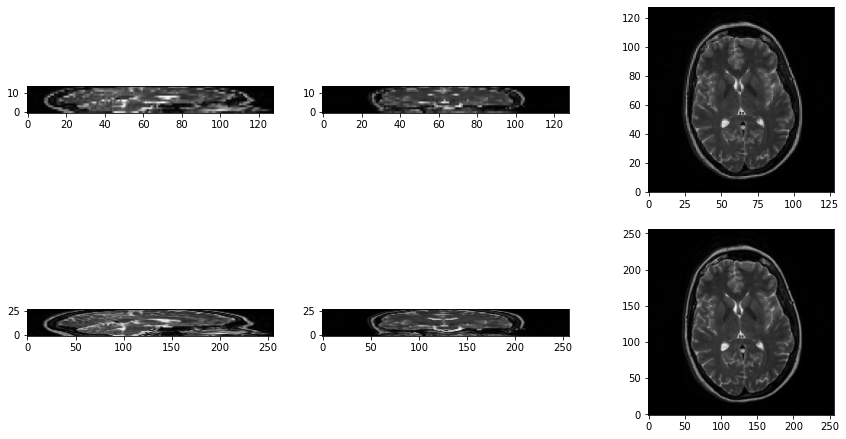

In [7]:
comp_image = tio.ScalarImage(image_path)[DATA].squeeze().numpy()
source_image = tio.ScalarImage(source_path)[DATA].squeeze().numpy()
print(scans[3])

plot_images(comp_image,source_image)